Import all necessary libraries and install everything you need for training:

In [15]:
# install the libraries necessary for data wrangling, prediction and result analysis
import gc
import pandas as pd
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from simpletransformers.classification import ClassificationModel
from sklearn.metrics import f1_score, confusion_matrix
import json
gc.collect()
torch.cuda.empty_cache()

### Import the data

In [ ]:
# CORE
CORE_train_df = pd.read_csv("data/CORE_final_train.csv")
CORE_dev_df = pd.read_csv("data/CORE_final_dev.csv")
CORE_test_df = pd.read_csv("data/CORE_final_test.csv")

print("CORE train shape: {}, Dev shape: {}, Test shape: {}.".format(CORE_train_df.shape, CORE_dev_df.shape, CORE_test_df.shape))

CORE train shape: (20350, 2), Dev shape: (6784, 2), Test shape: (6784, 2).


In [ ]:
# Slovene GINCO
SL_GI_train_df = pd.read_csv("data/SI_GINCO_train.csv")
SL_GI_dev_df = pd.read_csv("data/SI_GINCO_dev.csv")
SL_GI_test_df = pd.read_csv("data/SI_GINCO_test.csv")

print("Slovene GINCO train shape: {}, Dev shape: {}, Test shape: {}.".format(SL_GI_train_df.shape, SL_GI_dev_df.shape, SL_GI_test_df.shape))

Slovene GINCO train shape: (486, 2), Dev shape: (162, 2), Test shape: (162, 2).


In [ ]:
# MT GINCO
MT_GI_train_df = pd.read_csv("data/MT_GINCO_train.csv")
MT_GI_dev_df = pd.read_csv("data/MT_GINCO_dev.csv")
MT_GI_test_df = pd.read_csv("data/MT_GINCO_test.csv")

print("MT GINCO train shape: {}, Dev shape: {}, Test shape: {}.".format(MT_GI_train_df.shape, MT_GI_dev_df.shape, MT_GI_test_df.shape))

MT GINCO train shape: (486, 2), Dev shape: (162, 2), Test shape: (162, 2).


## Training and testing

We will use the trilingual CroSloEngual BERT model (https://huggingface.co/EMBEDDIA/crosloengual-bert)

In [ ]:
# Open the main results file:

previous_results_file = open("results-crosloengualbert/main-classification-results-crosloengualbert.json")
previous_results = json.load(previous_results_file)
len(previous_results)

15

In [6]:
def training(train_df,epoch_number):
    """
    This function takes the train dataset and the desired epoch_number and trains the CroSloEngual BERT model on it.

    Args:
    - train_df (pandas DataFrame): CORE_train_df, SL_GI_train_df or MT_GI_train_df
    - epoch_number (int): 6 if CORE_train_df, else: 90 

    Returns:
    - the model which can be used for inferring predictions
    """

    # Create a list of labels
    LABELS = train_df.labels.unique().tolist()

    # Define the model
    model = ClassificationModel(
    "bert", "EMBEDDIA/crosloengual-bert",
    num_labels=len(LABELS),
    use_cuda=True,
    args= {
            "overwrite_output_dir": True,
            "num_train_epochs": epoch_number,
            "labels_list": LABELS,
            "learning_rate": 1e-5,
            "no_cache": True,
            "no_save": True,
            "max_seq_length": 512,
            "save_steps": -1,
            "silent":True,
            }
    )

    # Train the model on train data
    model.train_model(train_df)

    print("Training is finished!")

    return model

In [7]:
def testing(model, model_name, test_df, test_name):
    """
    This function takes the test dataset and applies the trained model on it to infer predictions.
    It also prints and saves a confusion matrix, calculates the F1 scores and saves the results in a list of results.

    Args:
    - model (SimpleTransformers model): the model, trained in the training function: train_on_CORE, train_on_SI_GINCO or train_on_MT_GINCO
    - model_name (str): "SI_GINCO", "MT_GINCO", "CORE"
    - test_df (pandas DataFrame): CORE_test_df, SL_GI_test_df, or MT_GI_test_df
    - test_name
    """
    # Get the true labels
    y_true = test_df.labels

    LABELS = test_df.labels.unique().tolist()

    # Calculate the model's predictions on test
    def make_prediction(input_string):
        return model.predict([input_string])[0][0]

    y_pred = test_df.text.apply(make_prediction)

    # Calculate the scores
    macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    micro = f1_score(y_true, y_pred, labels=LABELS,  average="micro")
    print(f"Macro f1: {macro:0.3}, Micro f1: {micro:0.3}")

    # Plot the confusion matrix:
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    plt.figure(figsize=(9, 9))
    plt.imshow(cm, cmap="Oranges")
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, '{:d}'.format(z), ha='center', va='center')
    classNames = LABELS
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=90)
    plt.yticks(tick_marks, classNames)
    plt.title(f"Trained on {model_name}, tested on {test_name}")

    plt.tight_layout()
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    #fig1.savefig(f"Confusion-matrix-{model_name}-test-on-{test_name}.png",dpi=100)

    # Save the results:
    rezdict = {
        "trained_on": model_name,
        "tested_on": test_name,
        "microF1": micro,
        "macroF1": macro,
        "y_true": y_true.tolist(),
        "y_pred": y_pred.tolist(),
        }
    previous_results.append(rezdict)

    #Save intermediate results (just in case)
    backup = []
    backup.append(rezdict)
    with open(f"backup-results-{model_name}-{test_name}-CroSloEngualBERT.json", "w") as backup_file:
        json.dump(backup,backup_file, indent= "")

Some weights of the model checkpoint at EMBEDDIA/crosloengual-bert were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model chec

Training is finished!
Macro f1: 0.579, Micro f1: 0.735


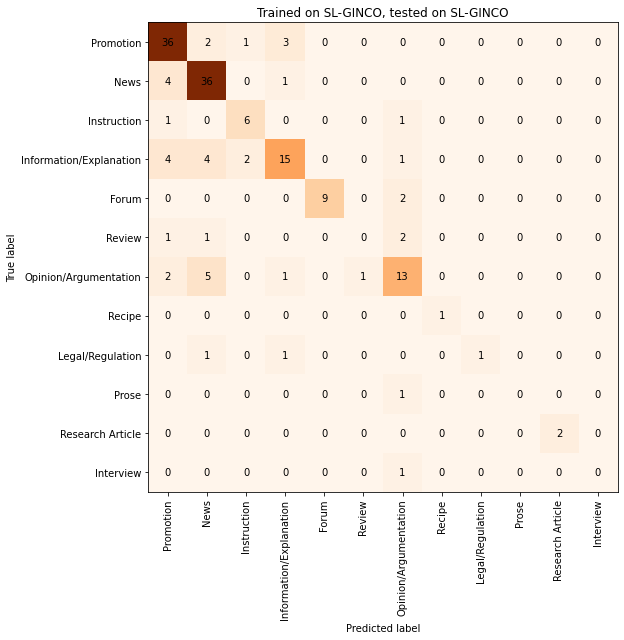

Macro f1: 0.36, Micro f1: 0.524


<Figure size 432x288 with 0 Axes>

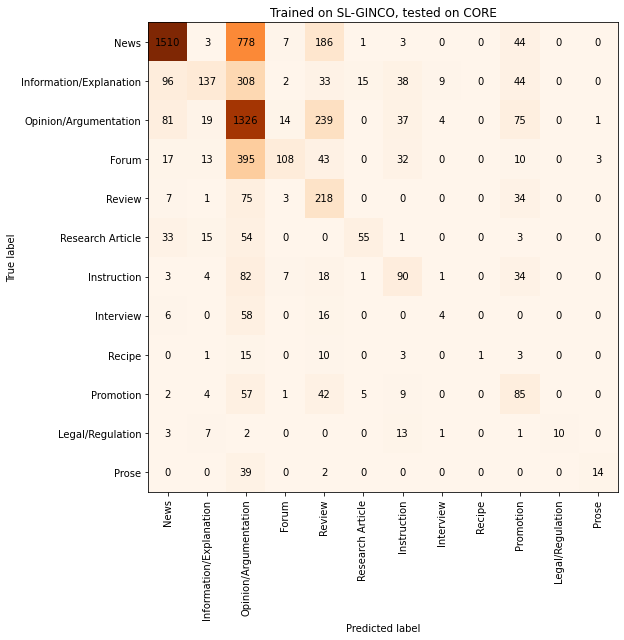

<Figure size 432x288 with 0 Axes>

In [ ]:
# Execute all of the experiments

# train on SL_GINCO
train_on_SI_GINCO = training(SL_GI_train_df, 90)
# train on SL_GINCO, test on SL_GINCO
testing(train_on_SI_GINCO,"SL-GINCO", SL_GI_test_df,"SL-GINCO")

# Save the file with updated results.
with open("results-crosloengualbert/main-classification-results-crosloengualbert.json", "w") as results_file:
    json.dump(previous_results,results_file, indent= "")

# Train on SL GINCO, test on CORE
testing(train_on_SI_GINCO,"SL-GINCO", CORE_test_df, "CORE")

# Save the file with updated results.
with open("results-crosloengualbert/main-classification-results-crosloengualbert.json", "w") as results_file:
    json.dump(previous_results,results_file, indent= "")

Some weights of the model checkpoint at EMBEDDIA/crosloengual-bert were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model chec

Training is finished!
Macro f1: 0.43, Micro f1: 0.71


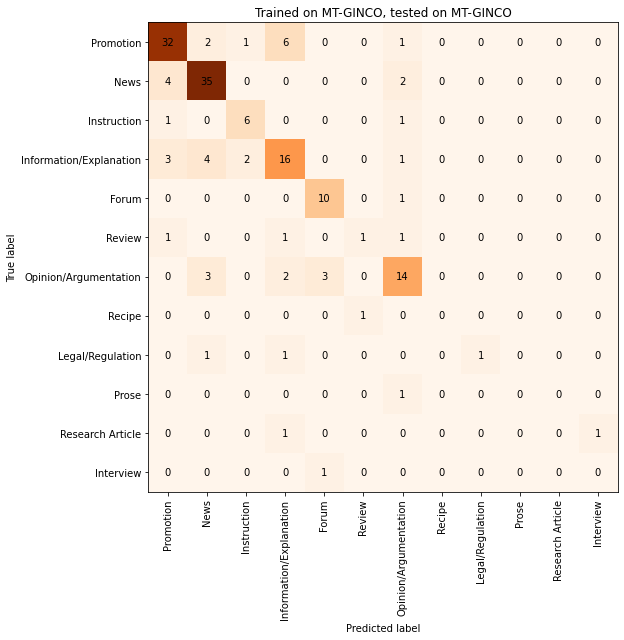

Macro f1: 0.402, Micro f1: 0.584


<Figure size 432x288 with 0 Axes>

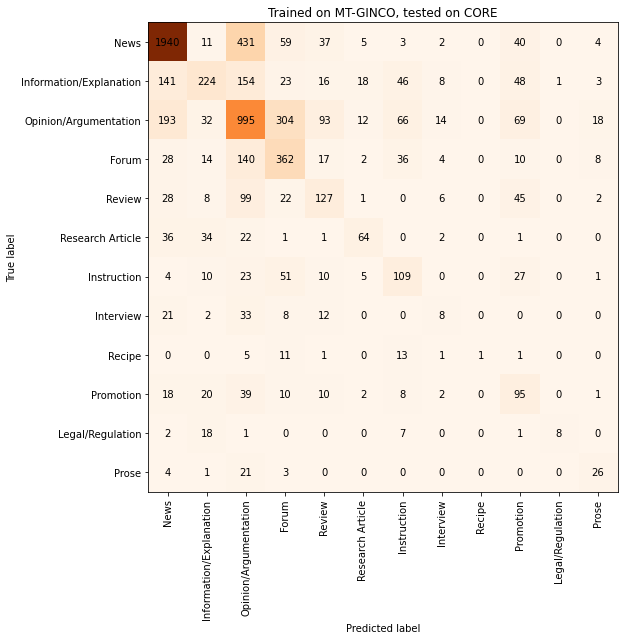

<Figure size 432x288 with 0 Axes>

In [ ]:
# Train on MT_GINCO
train_on_MT_GINCO = training(MT_GI_train_df, 90)
# Train on MT_GINCO, test on MT_GINCO
testing(train_on_MT_GINCO,"MT-GINCO", MT_GI_test_df, "MT-GINCO")

# Save the file with updated results.
with open("results-crosloengualbert/main-classification-results-crosloengualbert.json", "w") as results_file:
    json.dump(previous_results,results_file, indent= "")

# Train on MT_GINCO, test on CORE
testing(train_on_MT_GINCO,"MT-GINCO", CORE_test_df, "CORE")

# Save the file with updated results.
with open("results-crosloengualbert/main-classification-results-crosloengualbert.json", "w") as results_file:
    json.dump(previous_results,results_file, indent= "")

Some weights of the model checkpoint at EMBEDDIA/crosloengual-bert were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model chec

Training is finished!
Macro f1: 0.556, Micro f1: 0.568


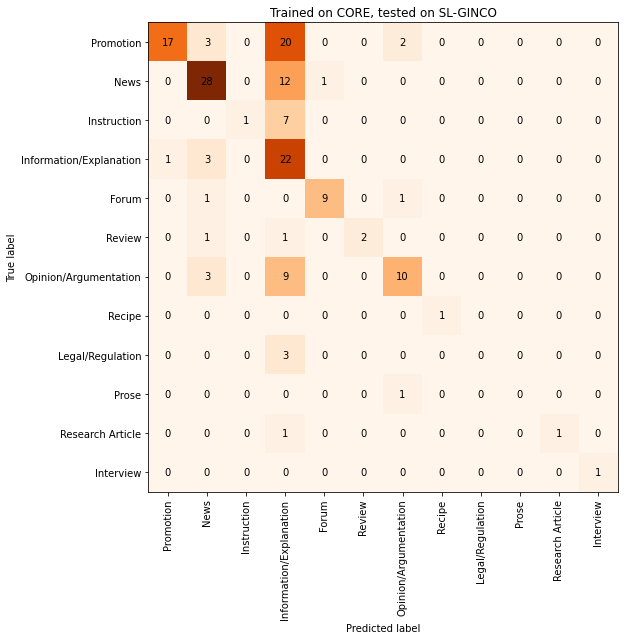

Macro f1: 0.535, Micro f1: 0.617


<Figure size 432x288 with 0 Axes>

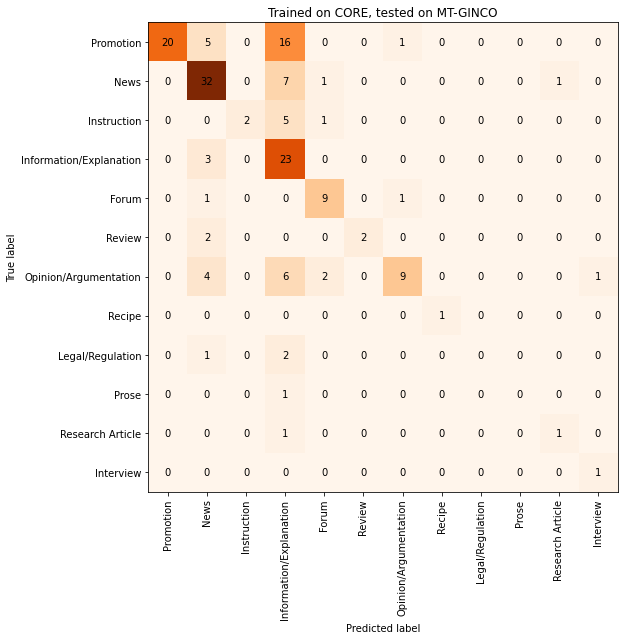

Macro f1: 0.705, Micro f1: 0.76


<Figure size 432x288 with 0 Axes>

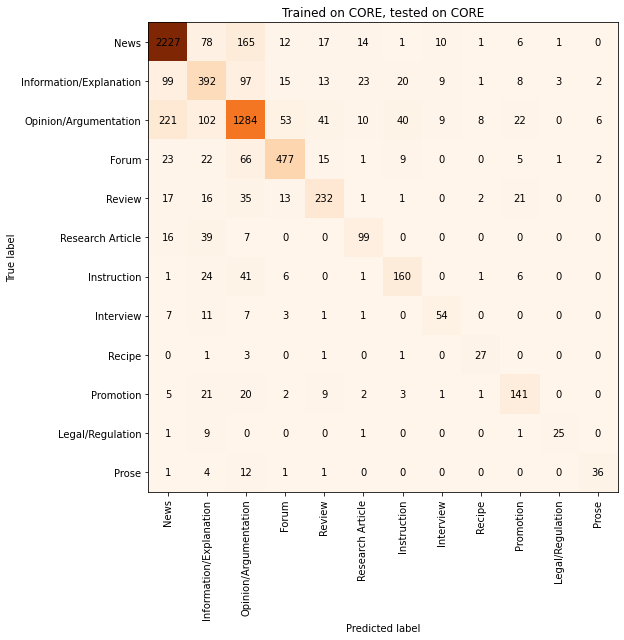

<Figure size 432x288 with 0 Axes>

In [ ]:
# Train on CORE
train_on_CORE = training(CORE_train_df, 6)
# Train on CORE, test on SL-GINCO
testing(train_on_CORE,"CORE", SL_GI_test_df,"SL-GINCO")

# Save the file with updated results.
with open("results-crosloengualbert/main-classification-results-crosloengualbert.json", "w") as results_file:
    json.dump(previous_results,results_file, indent= "")

# Train on CORE, test on MT-GINCO
testing(train_on_CORE,"CORE", MT_GI_test_df, "MT-GINCO")

# Save the file with updated results.
with open("results-crosloengualbert/main-classification-results-crosloengualbert.json", "w") as results_file:
    json.dump(previous_results,results_file, indent= "")

# Train on CORE, test on CORE
testing(train_on_CORE,"CORE", CORE_test_df, "CORE")

# Save the file with updated results.
with open("results-crosloengualbert/main-classification-results-crosloengualbert.json", "w") as results_file:
    json.dump(previous_results,results_file, indent= "")

In [ ]:
# Clean the GPU cache
cuda.select_device(0)
cuda.close()
cuda.select_device(0)
torch.cuda.empty_cache()